References:
- https://qiita.com/gensal/items/613d04b5ff50b6413aa0
- https://mbernste.github.io/posts/vae/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc

In [2]:
# Create transform to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# Download MNIST dataset
trainval_data = MNIST(root="./data", train=True, download=True, transform=transform)

# Split data to train and val
train_size = int(len(trainval_data) * 0.8)
val_size = int(len(trainval_data) * 0.2)
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

BATCH_SIZE = 100

train_loader = DataLoader(dataset=train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

val_loader = DataLoader(dataset=val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=4)

print("train data size: ",len(train_data))
print("train iteration number: ",len(train_data)//BATCH_SIZE)
print("val data size: ",len(val_data))
print("val iteration number: ",len(val_data)//BATCH_SIZE)

train data size:  48000
train iteration number:  480
val data size:  12000
val iteration number:  120


images_size: torch.Size([100, 1, 28, 28])
label: tensor([8, 0, 0, 2, 1, 1, 8, 1, 9, 9, 9, 9, 7, 4, 2, 6, 1, 1, 9, 5, 9, 9, 9, 1,
        9, 2, 2, 9, 6, 4, 3, 1, 1, 5, 3, 4, 6, 9, 8, 3, 1, 5, 0, 6, 1, 1, 4, 8,
        2, 2, 9, 5, 1, 9, 7, 0, 9, 9, 6, 1, 5, 7, 7, 4, 6, 1, 0, 0, 2, 7, 1, 1,
        1, 0, 2, 5, 2, 6, 2, 0, 8, 2, 0, 4, 4, 4, 9, 0, 3, 8, 4, 5, 8, 6, 7, 7,
        6, 4, 5, 3])
100


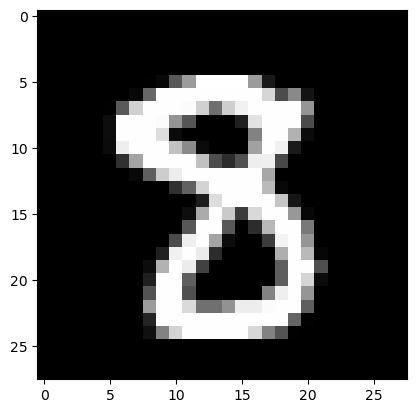

In [3]:
images, labels = next(iter(train_loader)) #Images, labels in first batch.
print("images_size:",images.size()) # [batch_size, channel, height, width]
print("label:",labels)
print(len(labels))

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

Fully connected NN-based VAE

In [9]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lr = nn.Linear(28*28, 300)
        self.lr2 = nn.Linear(300, 100)
        self.lr_ave = nn.Linear(100, z_dim)
        self.lr_var = nn.Linear(100, z_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.lr2(self.relu(self.lr(x))))
        ave = self.lr_ave(x)
        log_var = self.lr_var(x)

        # Reparameterization Trick
        epsilon = torch.randn_like(ave)
        z = ave + epsilon * torch.exp(log_var / 2)
        return z, ave, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.lr = nn.Linear(z_dim, 100)
        self.lr2 = nn.Linear(100, 300)
        self.lr3 = nn.Linear(300, 28*28)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.lr3(self.relu(self.lr2(self.relu(self.lr(x))))))
        x = torch.sigmoid(x)
        return x

class VAE(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    
    def forward(self, x):
        z, ave, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z, ave, log_var
        

In [10]:
def loss_function(output, input, ave, log_var):
	reconstruction_loss = F.binary_cross_entropy(output, input, reduction='sum')
	kl_loss = -0.5 * torch.sum(1 + log_var - ave**2 - log_var.exp())
	loss = reconstruction_loss + kl_loss
	return loss

In [17]:
z_dim = 2
num_epochs = 20

# Check if MPS (Apple GPU support) is available and use it; otherwise, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = VAE(z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: mps


In [18]:
summary = {"train_loss": [], "val_loss": [], "ave": [], "log_var": [], "z": [], "labels": []}

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[15], gamma=0.1)
for epoch in range(num_epochs):
    model.train()
    for batch_num, (x, labels) in enumerate(train_loader):
        input = x.to(device).view(-1, 28*28).to(torch.float32)
        output, z, ave, log_var = model(input)

        summary["ave"].append(ave)
        summary["log_var"].append(log_var)
        summary["z"].append(z)
        summary["labels"].append(labels)
        loss = loss_function(output, input, ave, log_var)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_num % 100 == 0:
            print(f'Epoch: {epoch + 1}, loss: {loss:.4f}')
        summary["train_loss"].append(loss)
    
    model.eval()
    with torch.inference_mode():
        for x, labels in val_loader:
            input = x.to(device).view(-1, 28*28).to(torch.float32)
            output, z, ave, log_var = model(input)

            loss = loss_function(output, input, ave, log_var)
            summary["val_loss"].append(loss)
        print(f'Epoch: {epoch + 1}, val_loss: {loss:.4f}')
    
    scheduler.step()


Epoch: 1, loss: 55749.0781
Epoch: 1, loss: 54340.7930
Epoch: 1, loss: 54338.9922
Epoch: 1, loss: 54338.2383
Epoch: 1, loss: 54347.4258
Epoch: 1, val_loss: 54328.5078
Epoch: 2, loss: 54335.4102
Epoch: 2, loss: 54336.6797
Epoch: 2, loss: 54338.9297
Epoch: 2, loss: 54342.3711
Epoch: 2, loss: 54336.5703
Epoch: 2, val_loss: 54321.4727
Epoch: 3, loss: 54322.3359
Epoch: 3, loss: 54337.1328
Epoch: 3, loss: 54337.9102
Epoch: 3, loss: 54350.9258
Epoch: 3, loss: 54328.8359
Epoch: 3, val_loss: 54332.5859
Epoch: 4, loss: 54341.5742
Epoch: 4, loss: 54328.1289
Epoch: 4, loss: 54341.3164
Epoch: 4, loss: 54331.5195
Epoch: 4, loss: 54328.5820
Epoch: 4, val_loss: 54336.4102
Epoch: 5, loss: 54318.9141
Epoch: 5, loss: 54341.6445
Epoch: 5, loss: 54333.9492
Epoch: 5, loss: 54314.1875
Epoch: 5, loss: 54320.5625
Epoch: 5, val_loss: 54345.8789
Epoch: 6, loss: 54331.0938
Epoch: 6, loss: 54337.6797
Epoch: 6, loss: 54319.5195
Epoch: 6, loss: 54342.4414
Epoch: 6, loss: 54337.6133
Epoch: 6, val_loss: 54330.1758
Epoc

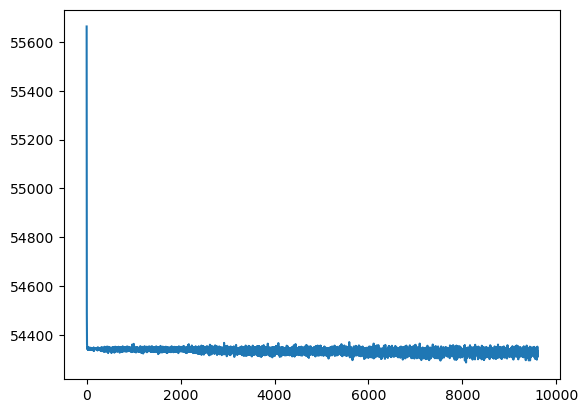

In [16]:
train_loss_tensor = torch.stack(summary["train_loss"])
train_loss_np = train_loss_tensor.to('cpu').detach().numpy().copy()
plt.plot(train_loss_np)

確立モデルに潜在変数Zを導入したら複雑な分布をより単純な分布を使って表すことが可能になります。潜在変数を導入することは，同時分布
を設計することに相当します。ここが全ての始まりです。観測データと潜在変数にどのような依存関係があるのかを同時分布として設定してしまうわけです。

変分ベイズを含む従来のベイズ推定の手法では，計算が煩雑になるという欠点があります。一方で，VAEでは近似分布のみならず，真の分布もDNNによって推定しますので，確率的勾配法を用いて一気通貫にパラメータを最適化することができます。

EM algorithm:
 - 潜在変数を含む確率モデルの点推定を行う手法。
 - Mアルゴリズムでは，潜在変数をとパラメータを区別します。
 - EMアルゴリズムではを計算できるという立場を取ります。

Variational Bayes:
 - 変分ベイズは潜在変数を含む確率モデルのベイズ推定を行うための手法です。
 - 潜在変数をとパラメータを区別せずに、両者を一括してZと表します。
 - 変分ベイズではを計算できないという立場を取ります。
 - 変分ベイズは，事後分布を別の新しい分布で近似してしまおうという大胆かつ汎用性の高い手法です。

*Ref: https://academ-aid.com/ml/vae*